## Read in the appropriate packages

In [1]:
#!pip install pmdarima

In [2]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA

import pmdarima as pm #auto arima


# White Noise Refresher

In summary:

1. White noise time series is defined by a zero mean, constant variance, and no correlation with past lags.
2. If your time series is white noise, it cannot be predicted, and if your forecast residuals are not white noise, you may be able to improve your model.
3. Descriptive statistics and plots such as autocorrelation, line plots, and residual plots can be used on your time series to check if it is white noise.


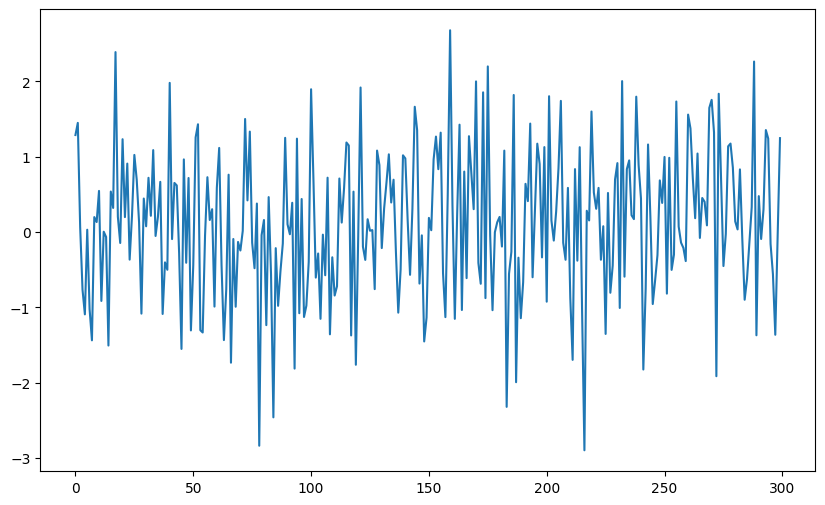

In [3]:
# Let us create a Gaussian White Noise series
# Create a list of 300 random Gaussian variables using the gauss() function
# Draw variables from a Gaussian distribution with a mean (mu) of 0.0 and a standard deviation (sigma) of 1.0.

# seed random number generator
seed(1)
# create white noise series
series = [gauss(0.0, 1.0) for i in range(300)]
series = Series(series)

# line plot
plt.figure(figsize=(10,6))
series.plot()
plt.show()

In [4]:
series.describe()

count    300.000000
mean       0.115328
std        0.970553
min       -2.896251
25%       -0.506559
50%        0.131935
75%        0.789927
max        2.678687
dtype: float64

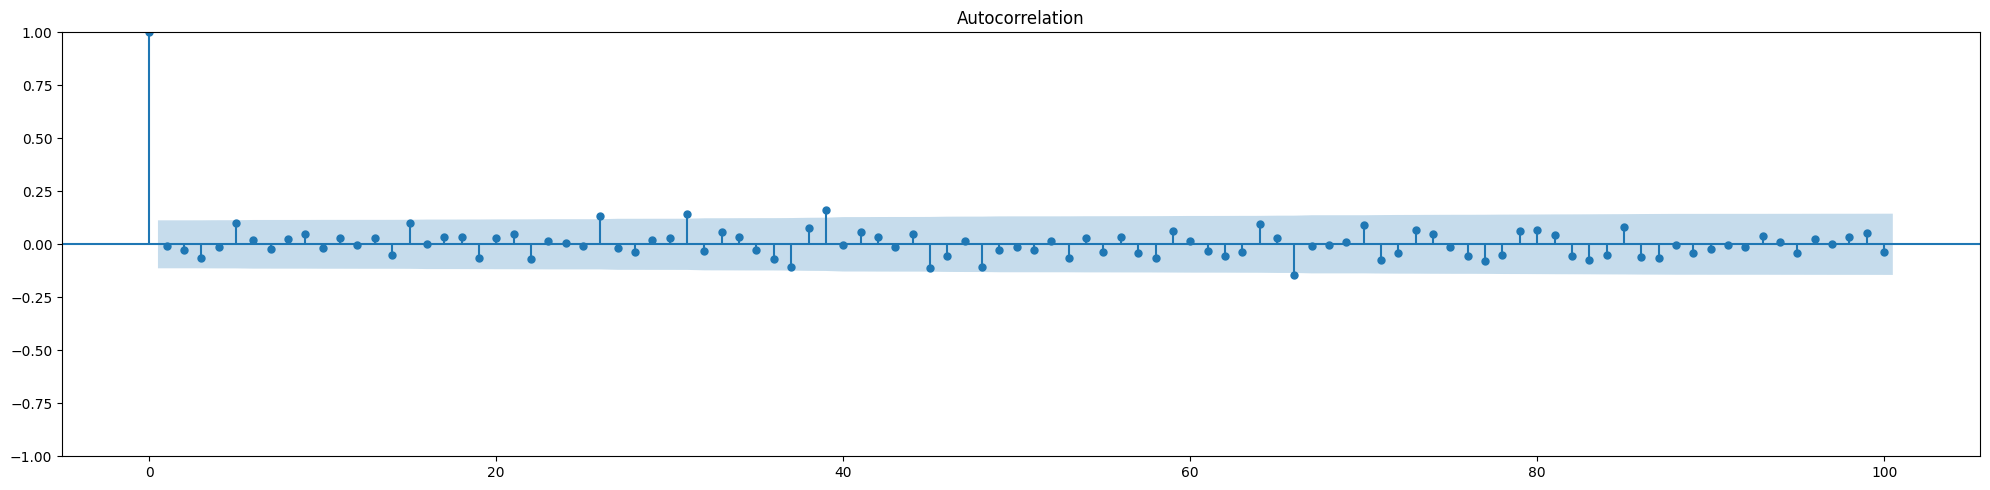

In [5]:
# autocorrelation plot - correlation between lagged variables - see excel sheet
#check if the data is stationary

# autocorrelation plot of the dataset
fig = plot_acf(series, lags=100)
fig.set_size_inches((20, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Read in the monthly anti-diabetic drug sales in Australia dataset

Download the data from the the gdrive: https://drive.google.com/drive/folders/1JyHJPZGgJDJL5WcLaxwmfij2bcuiF08P?usp=drive_link

In [7]:
drug_sales_df = pd.read_csv('/content/drive/MyDrive/F23 Mini-2 Time Series Forecasting in Python/Week 3/Data and Python Notebook/drug_sales_australia.csv',
                            parse_dates=['date'],
                            index_col=['date'])
drug_sales_df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


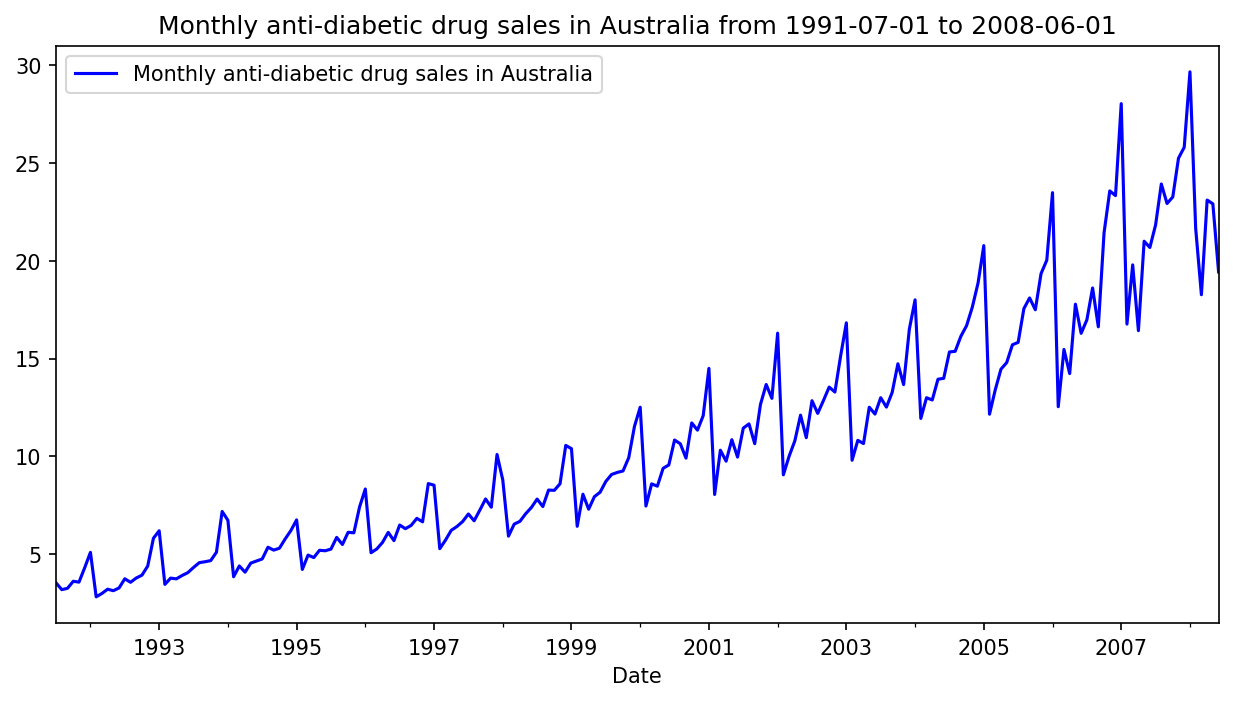

In [8]:
# Visualizing the series

# to set the plot size
plt.figure(figsize=(10, 5), dpi=150) #dpi = resolution. default 100.

# in plot method we set the label and color of the curve.
drug_sales_df['value'].plot(label='Monthly anti-diabetic drug sales in Australia', color='blue')

# adding title to the plot
plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format('1991-07-01', '2008-06-01'))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


In [9]:
#questions
#1. Is this white noise?
#1. trend or seasonality?
#2. additive or multiplicative trend and seasonality?


In [10]:
drug_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 1991-07-01 to 2008-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   204 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


## 2. Exploratory Data Analysis (EDA)


In [11]:
# 1. Descriptive Statistics
drug_sales_df.describe()

,value
count,204.000000
mean,10.694430
std,5.956998
min,2.814520
25%,5.844095
50%,9.319345
75%,14.289964
max,29.665356


<Axes: >

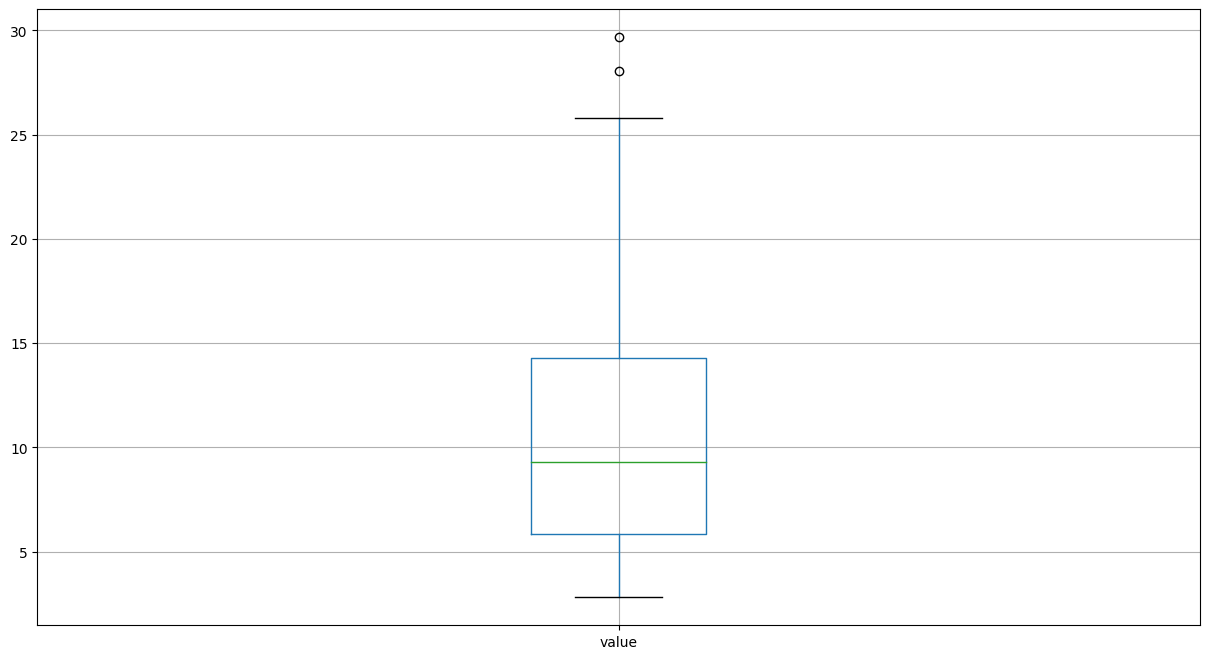

In [12]:
plt.figure(figsize=(15,8))
drug_sales_df.boxplot()

In [13]:
# ask students - why do people look at distributions of data? Slide 11

In [14]:
# 2. Check for missing values
drug_sales_df.isnull().sum()

value    0
dtype: int64

In [15]:
# 3. Find the indexes that are missing
pd.date_range(start = drug_sales_df.index.min(), end = drug_sales_df.index.max(), freq='MS').difference(drug_sales_df.index)


DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

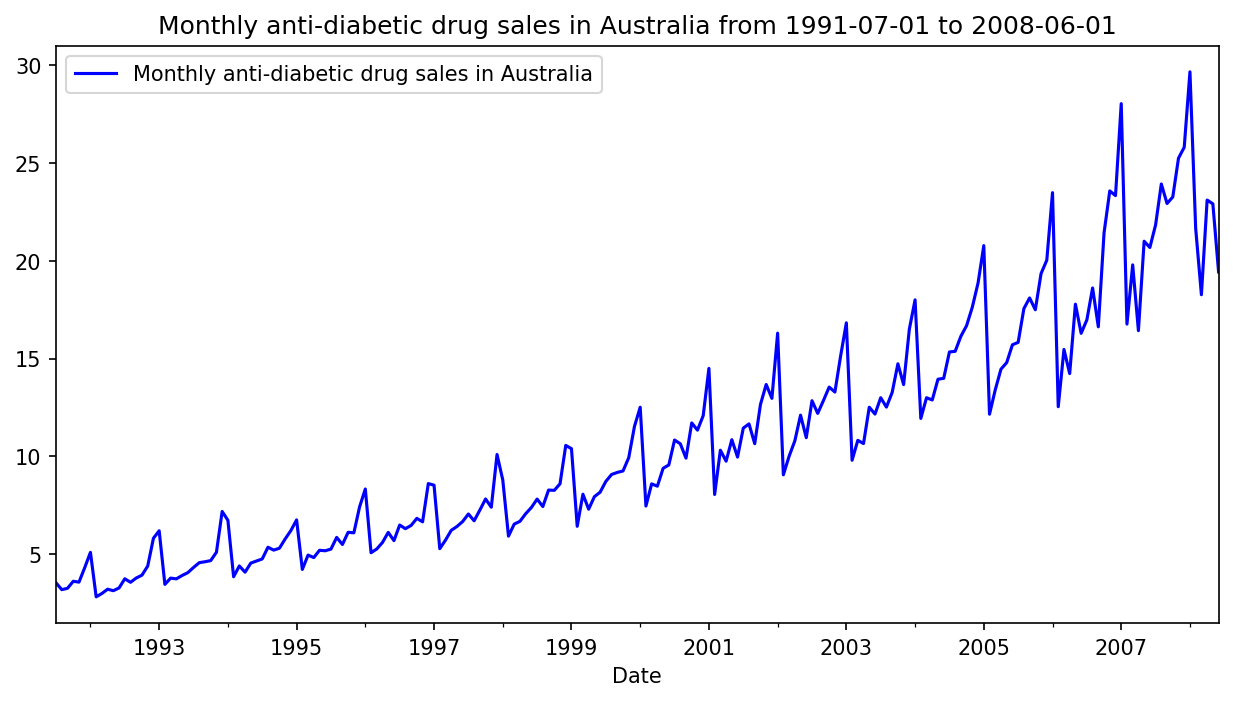

In [16]:
# Visualizing the series

# to set the plot size
plt.figure(figsize=(10, 5), dpi=150) #dpi = resolution. default 100.

# in plot method we set the label and color of the curve.
drug_sales_df['value'].plot(label='Monthly anti-diabetic drug sales in Australia', color='blue')

# adding title to the plot
plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format('1991-07-01', '2008-06-01'))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


## Stationarity  

### Why Does Stationarity Matter in Time Series Analysis? Why do we have to make sure our data set is stationary before we can run different ARIMA models on it?

Stationarity is crucial in time series analysis because it ensures that the statistical properties of a time series remain constant over time. By removing trends and seasonality, stationarity allows us to focus on the underlying dynamics and capture autocorrelation effectively. ARIMA models assume stationarity and rely on it to make reliable predictions. Ensuring stationarity before applying ARIMA models is necessary to meet model assumptions and obtain accurate results.

1. Consider the forecasting problem. How do you forecast? If everything's different tomorrow then it's impossible to forecast, because everything's going to be different. So the key to forecasting is to find something that will be the same tomorrow, and extend that to tomorrow. Hence, a stationarized series is relatively easy to predict.

2. Statistical modeling methods assume or require the time series to be stationary to be effective. The ARIMA models predict that the mean and variance will be the same in the future as they have been in the past. A stationary time series will also allow us to obtain meaningful statistics such as means, variances, and correlations with other variables. These stats are only useful descriptors if the series is stationary.

3. As in the case of the monthly anti-diabetic drug sales, the series is consistently increasing over time. Hence, the sample mean and variance will grow with the size of the sample and the models will always underestimate the mean and variance in the future periods.

Ssource: https://towardsdatascience.com/why-does-stationarity-matter-in-time-series-analysis-e2fb7be74454

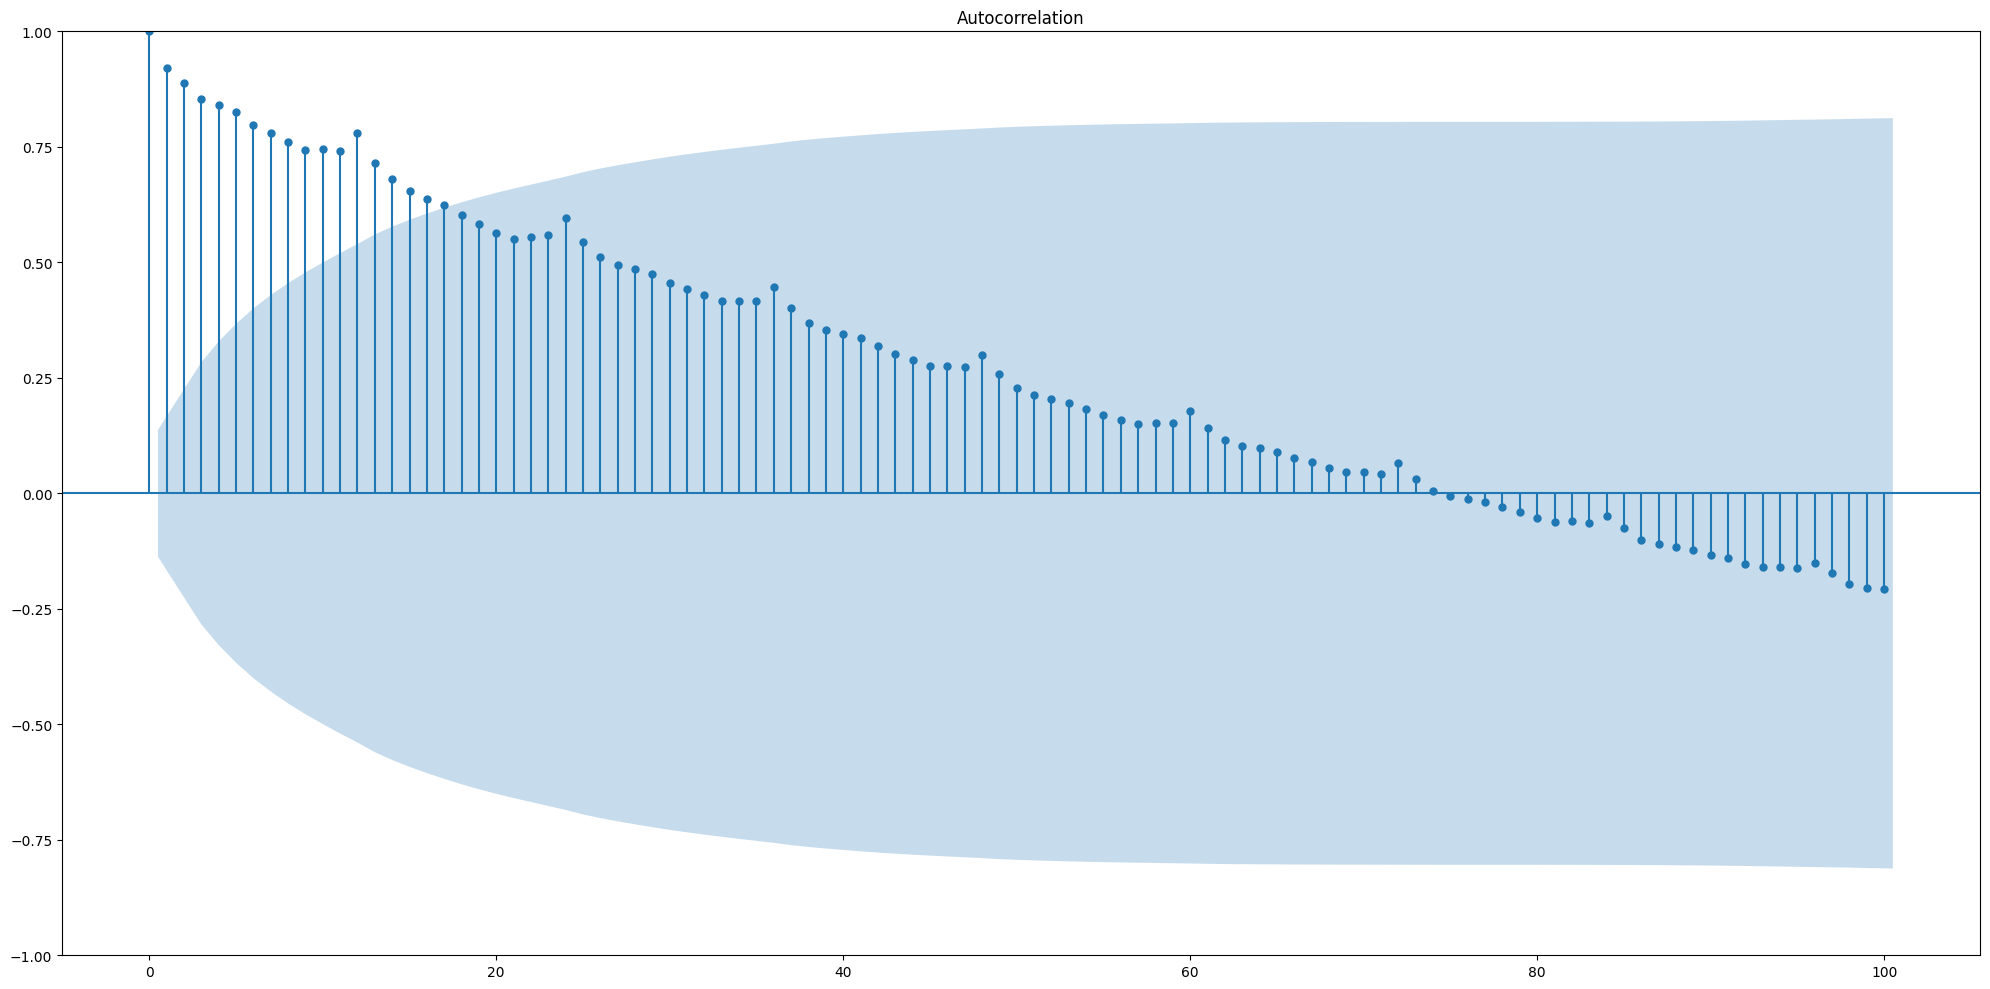

In [17]:
#check if the data is stationary

# autocorrelation plot of the dataset
fig = plot_acf(drug_sales_df, lags=100)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [18]:
#data has trend as well as seasonlity of 12 months

In [19]:
### Another example of stationary series (sine wave) vs white noise

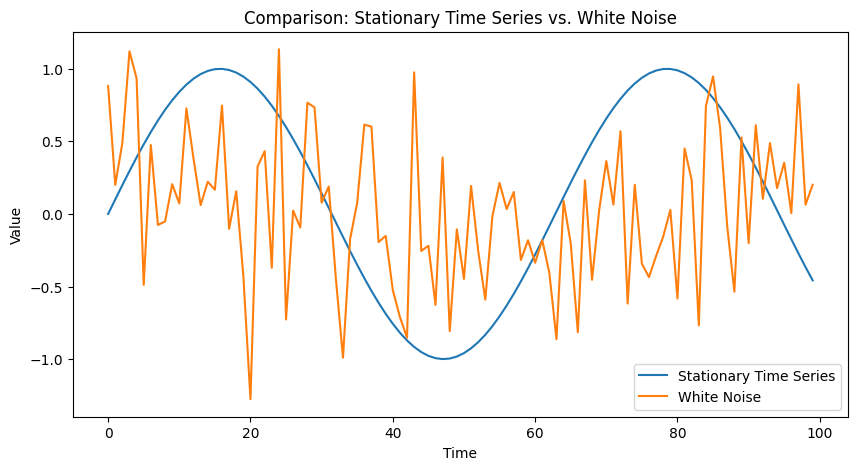

In [20]:
# Set seed for reproducibility
np.random.seed(0)

# Generate a stationary time series
time = np.arange(0, 100)
stationary_ts = np.sin(0.1 * time)

# Generate white noise
white_noise = np.random.normal(0, 0.5, size=100)

# Plot the stationary time series and white noise
plt.figure(figsize=(10, 5))
plt.plot(time, stationary_ts, label='Stationary Time Series')
plt.plot(time, white_noise, label='White Noise')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison: Stationary Time Series vs. White Noise')
plt.legend()
plt.show()

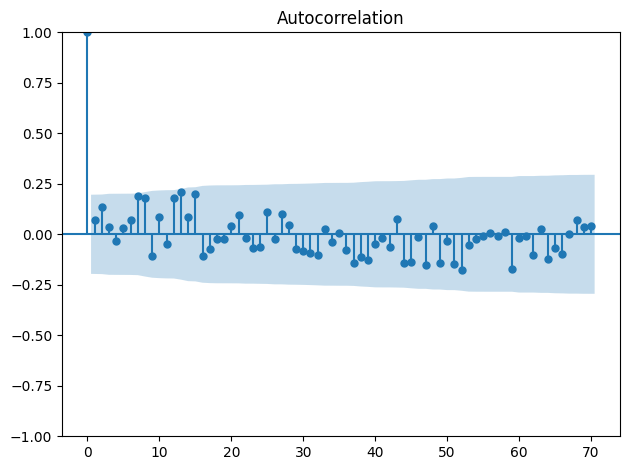

In [21]:
fig = plot_acf(white_noise, lags=70)
# Tight layout to realign things
fig.tight_layout()
plt.show()

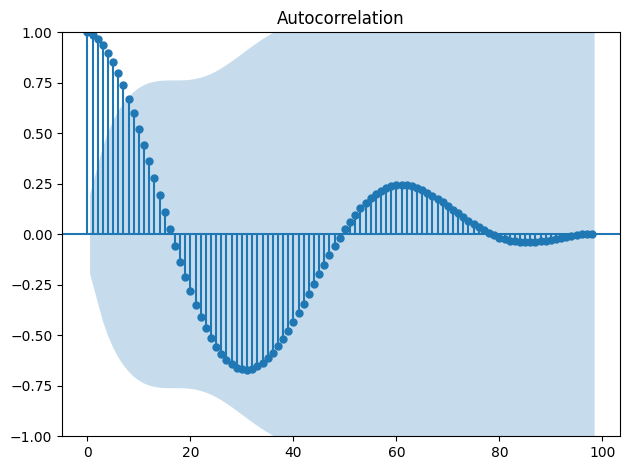

In [22]:
fig = plot_acf(stationary_ts, lags=98)
# Tight layout to realign things
fig.tight_layout()
plt.show()



## Unit Root Test - Augmented Dickey-Fuller (ADF) statistical test to check stationarity

In [23]:
result = adfuller(stationary_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -547557190348913.187500
p-value: 0.000000
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583



A sine wave is considered stationary despite its seasonality because the statistical properties of the time series remain constant over time. Although it exhibits a periodic pattern, the mean, variance, and autocovariance of the sine wave do not change, satisfying the definition of stationarity. Stationarity and seasonality are separate concepts, and a time series can be stationary while still displaying seasonality.

In [24]:
# let's check it for our time series

In [25]:
X = drug_sales_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.145186
p-value: 1.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


Running the test prints the test statistic value of 3.14. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset). As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of 3.14 is greater than the value of -2.87 at 5%. Also, the p-value is greater than 0.05.

This suggests that we fail to reject the null hypothesis with a significance level of 5%. Failing to reject the null hypothesis means that the process a unit root, and in turn that the time series is non-stationary.

## Differencing

One of the best ways to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

<Axes: xlabel='date'>

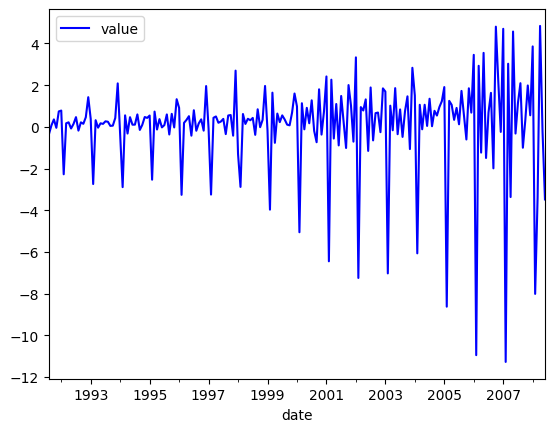

In [26]:
#create differenced dataset
first_diff_df = drug_sales_df.diff().dropna()
first_diff_df.plot(color='blue')

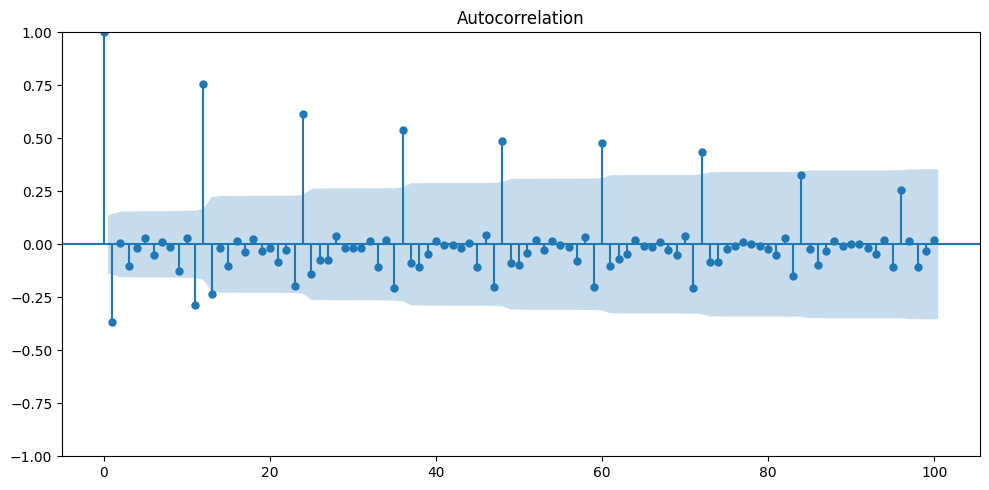

In [27]:
# autocorrelation plot of differenced dataset
fig = plot_acf(first_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [28]:
X = first_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.495172
p-value: 0.116653
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


From the ACF and line plot and the ADF test p-value we can deduce that the series is non-stationary. As we can see a seasonal pattern, let us apply seasonal differencing.

<Axes: xlabel='date'>

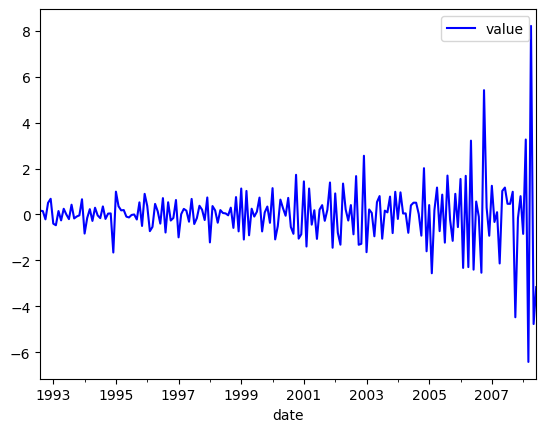

In [29]:
seasonal_diff_df = first_diff_df.diff(12).dropna()
seasonal_diff_df.plot(color = 'blue')

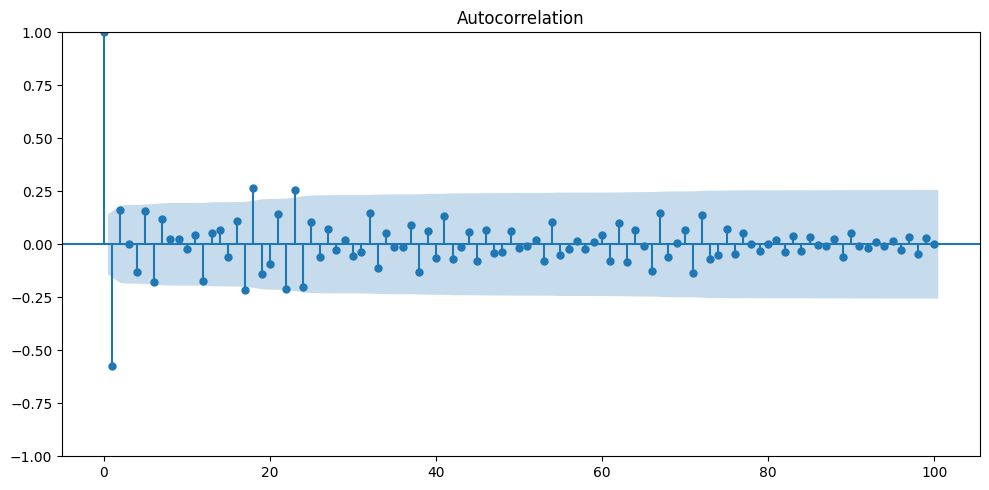

In [30]:
# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(seasonal_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [31]:
X = seasonal_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.783440
p-value: 0.000058
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


Since p-value is less than 0.05 we can reject the null hypothesis and the data is stationary.

In [32]:
#lets see what woul've happened if we seasonally differeced first

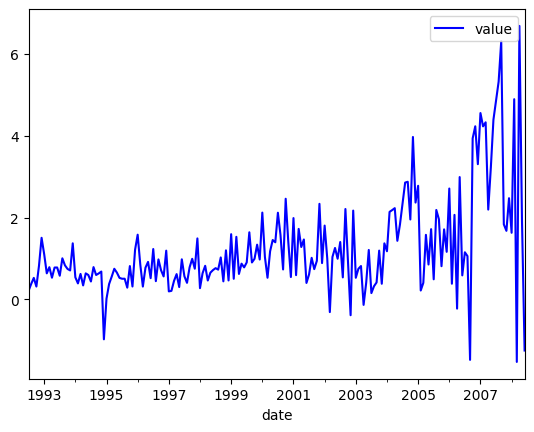

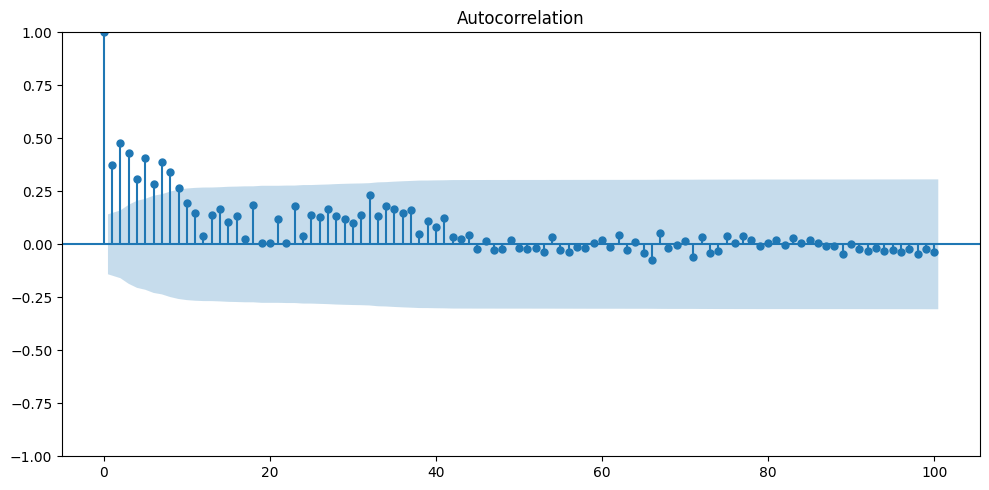

ADF Statistic: -2.092723
p-value: 0.247451
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


In [33]:
seasnl_diff_df = drug_sales_df.diff(12).dropna()
seasnl_diff_df.plot(color='blue')

fig = plot_acf(seasnl_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

X = seasnl_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

## Seasonal differencing and interpretation of differencing

When both seasonal and first differences are applied -
1. it makes no difference which is done first—the result will be the same.
2. If seasonality is strong, it is recommended that seasonal differencing be done first because sometimes the resulting series will be stationary and there will be no need for further first difference.

Also, it is important that if differencing is used, the differences are interpretable.
1. first differences are the change between one observation and the next.
2. seasonal differences are the change between one year to the next.

But taking lag 3 differences for yearly data, for example, results in a model which cannot be sensibly interpreted.


## Time to test out the forecasts - split data into train and test sets

In [34]:
drug_sales_df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


In [35]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(drug_sales_df, test_size=12, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 192
No. of testing examples: 12


In [36]:
train_data

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2007-02-01,16.763869
2007-03-01,19.792754
2007-04-01,16.427305


In [37]:
test_data

,value
date,
2007-07-01,21.834890
2007-08-01,23.930204
2007-09-01,22.930357
2007-10-01,23.263340
2007-11-01,25.250030
2007-12-01,25.806090
2008-01-01,29.665356
2008-02-01,21.654285
2008-03-01,18.264945


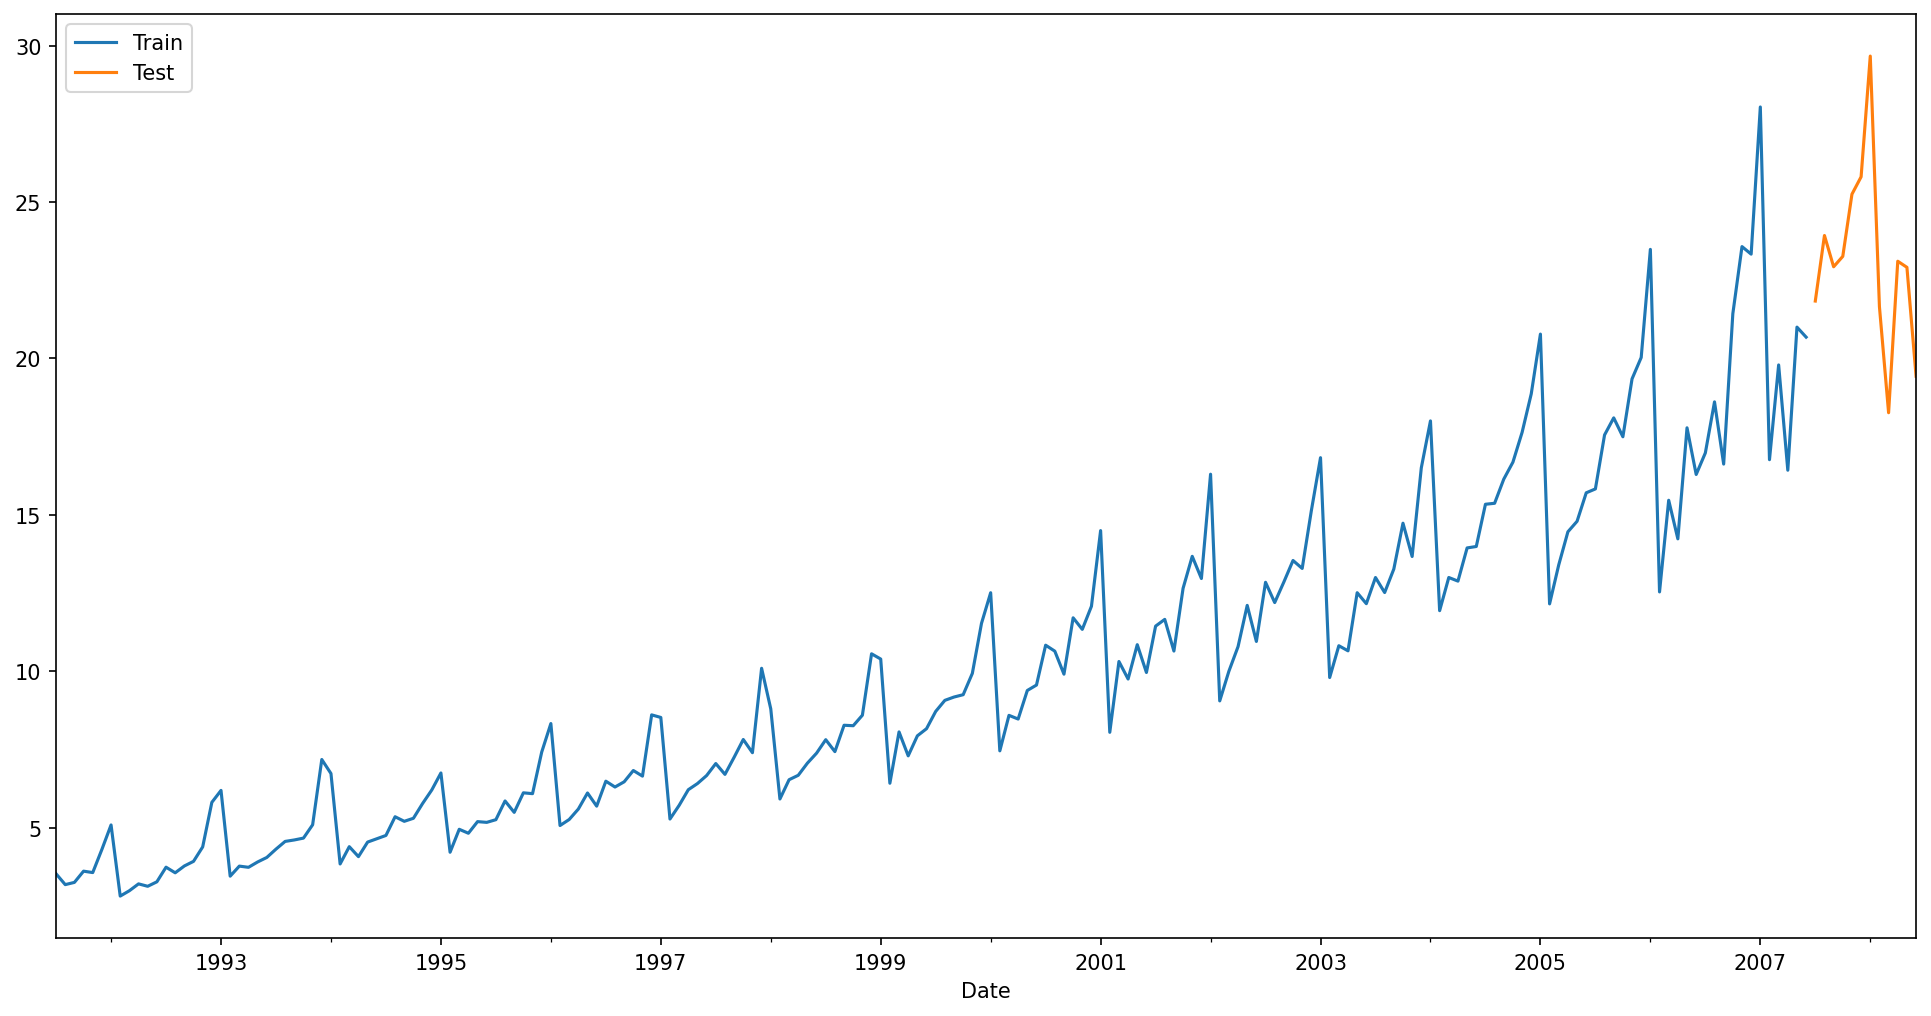

In [38]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
train_data['value'].plot(label='Train')
test_data['value'].plot(label='Test')

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


## Fitting Models - AR, MA, non-seasonal, and seasonal ARIMA Models

In [39]:
# Refer slides

ARIMA models cater to a suite of standard structures in time series data, and as such provide a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average.

1. AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
2. I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
3. MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Source:
1. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

### How to find the order of the AR (p) and MA (q) term?

You can find out the required number of AR and MA terms by inspecting the Autocorrelation (ACF) and Partial Autocorrelation (PACF) plot of the differenced time series.

What is Partial Autocorrelation?

Recall that an ACF plot shows the autocorrelations which measure the relationship between lagged values of a time series. Now if yt and yt−1 are correlated, then yt−1 and yt-2 must also be correlated. However, then yt and yt-2 might be correlated, simply because they are both connected to yt-1, rather than because of any new information contained in yt-2 that could be used in forecasting yt.

To overcome this problem, we can use partial autocorrelations. These measure the relationship between yt and  yt-k after removing the effects of lags 1,2,3,...,k-1.

ACF and PACF plots of the differenced time series helps us determine if we should use AR, MA, or both components.  

ACF plot - MA(q)
1. If the stationarized time series has positive autocorrealtion at lag 1, AR terms are best. If it has negative autocorrealtion at lag 1, MA terms are best.
2. Decay and cut off of the ACF gives us hints at what terms to use.

PACF plot - AR(p)
1. If the partial autocorrelation abruptly drops off at lag k, it indicates an AR model.
2. If it drops off gradually, it suggests an MA model.


In [40]:
# AR or MA?

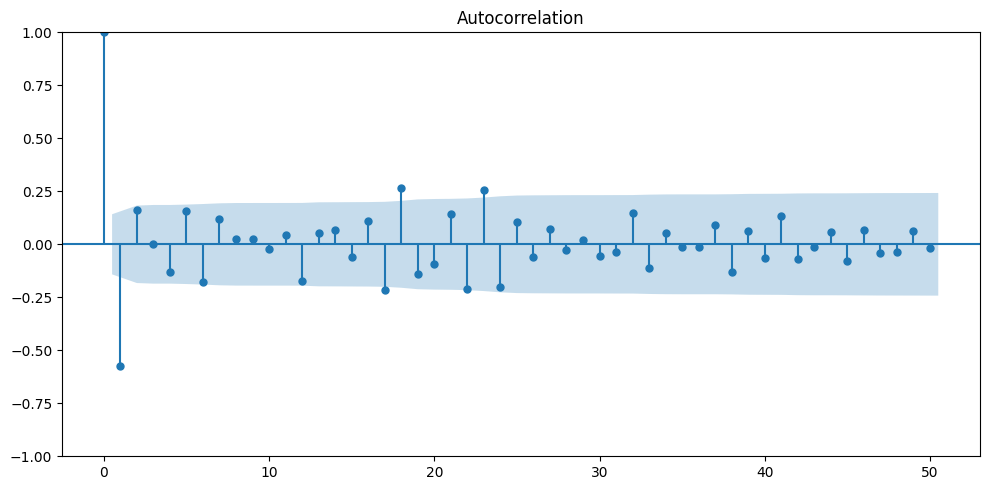

In [41]:
# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(seasonal_diff_df, lags=50)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

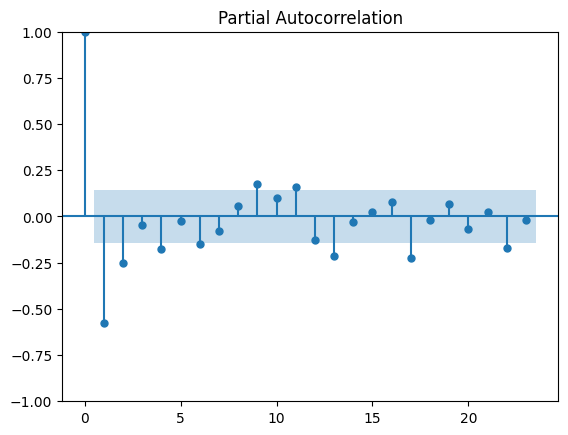

In [42]:
#plot PACF of the differenced time series.
plot_pacf(seasonal_diff_df)
plt.show()

In [43]:
# AR or MA?

### Build ARIMA manually

In [62]:
# p,d,q = 2,1,1 ARIMA Model
manual_model = sm.tsa.ARIMA(train_data, order=(2,1,1))
manual_model_fit = manual_model.fit()
print(manual_model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  192
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -388.544
Date:                Thu, 09 Nov 2023   AIC                            785.088
Time:                        01:34:33   BIC                            798.097
Sample:                    07-01-1991   HQIC                           790.358
                         - 06-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2753      0.126      2.191      0.028       0.029       0.522
ar.L2          0.0996      0.103      0.966      0.334      -0.102       0.302
ma.L1         -0.8552      0.078    -11.024      0.0

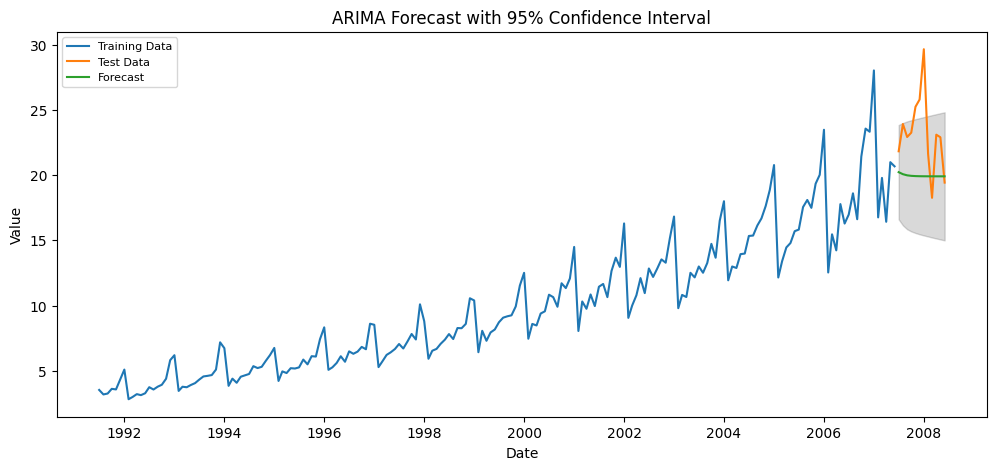

In [45]:
# Forecast
forecast_steps = 12
forecast_values = manual_model_fit.forecast(steps=forecast_steps)

# Calculate the standard errors of the forecasts
stderr = manual_model_fit.get_prediction(start=len(train_data), end=len(train_data) + forecast_steps - 1).se_mean

# Calculate lower and upper bounds for a 95% confidence interval
alpha = 0.05
z_score = 1.96  # for a 95% confidence interval
lower_bound = forecast_values - z_score * stderr
upper_bound = forecast_values + z_score * stderr

# Create pandas Series for forecasts and intervals
fc_series = pd.Series(forecast_values, index=test_data.index)
lower_series = pd.Series(lower_bound, index=test_data.index)
upper_series = pd.Series(upper_bound, index=test_data.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto ARIMA - Non seasonal

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [46]:
non_seasonal_auto_model = pm.auto_arima(train_data, start_p=0, start_q=0,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

print(non_seasonal_auto_model.summary())

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1473.879, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=844.283, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1279.130, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=802.660, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=794.855, Time=0.61 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=795.190, Time=1.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=799.333, Time=1.41 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=797.769, Time=0.74 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=785.896, Time=2.28 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=792.088, Time=1.60 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=788.158, Time=1.55 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=788.697, Time=2.01 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total 

In [47]:

# Forecast
n_periods = 12
fc_auto_nonseasonal, confint = non_seasonal_auto_model.predict(n_periods=n_periods, return_conf_int=True)

In [48]:
fc_auto_nonseasonal

2007-07-01    21.107307
2007-08-01    19.519591
2007-09-01    20.670859
2007-10-01    19.354526
2007-11-01    20.595266
2007-12-01    19.320129
2008-01-01    20.567025
2008-02-01    19.302869
2008-03-01    20.545023
2008-04-01    19.287856
2008-05-01    20.523868
2008-06-01    19.273138
Freq: MS, dtype: float64

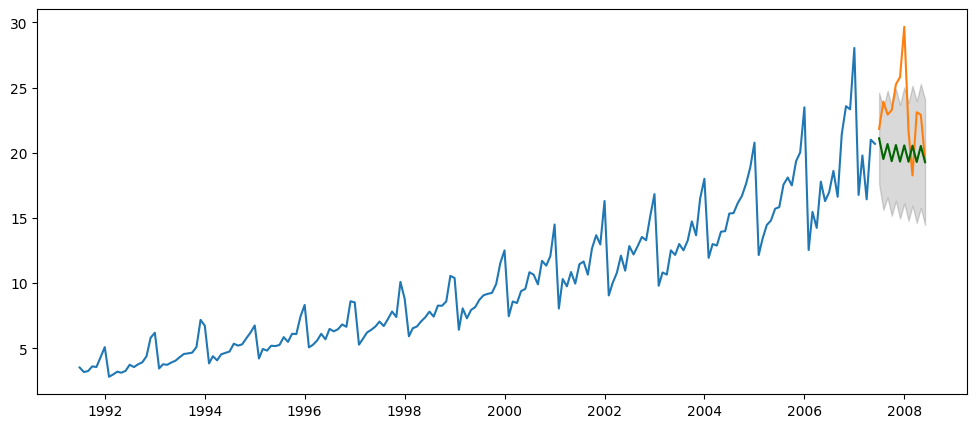

In [49]:
# make series for plotting purpose
fc_series_auto_nonseasonal = pd.Series(fc_auto_nonseasonal, index=test_data.index)
lower_series = pd.Series(confint[:, 0], index=test_data.index)
upper_series = pd.Series(confint[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='train')
plt.plot(test_data, label='test')
plt.plot(fc_series_auto_nonseasonal, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.show()

## Auto ARIMA Seasonal

In [50]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=422.169, Time=0.80 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=505.309, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=440.957, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=422.766, Time=0.51 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=423.219, Time=0.37 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=423.200, Time=1.42 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=421.304, Time=3.40 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=420.235, Time=5.55 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=422.207, Time=3.18 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=420.588, Time=1.53 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=420.770, Time=1.44 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=435.856, Time=2.31 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=420.069, Time=3.95 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=420.743, Time=1.71 sec
 ARIMA(2,1,1)(1,1,1)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(3, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -199.854
Date:                            Wed, 08 Nov 2023   AIC                            417.708
Time:                                    23:29:40   BIC                            446.395
Sample:                                07-01-1991   HQIC                           429.341
                                     - 06-01-2007                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5684      0.199     -2.853      0.004      -0.959      -0.178
ar.L2          0.3585      0.130      2.760      0.006       0.104       0.613
ar.L3          0.3405      0.077      4.416      0.000       0.189       0.492
ma.L1         -0.2248      0.231     -0.974      0.330      -0.677       0.227
ma.L2         -0.6160      0.171     -3.609      0.000      -0.951      -0.281
ar.S.L12      -0.5863      0.357     -1.643      0.100      -1.286       0.113
ma.S.L12       0.4531      0.353      1.284      0.199      -0.239       1.145
ma.S.L24      -0.2938      0.103     -2.852      0.004      -0.496      -0.092
sigma2         0.5347      0.042     12.711      0.000       0.452       0.617
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               161.13
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               8.91   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
# Forecast
n_periods = 12
fc_auto_seasonal, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

In [52]:
fc_auto_seasonal

2007-07-01    20.320234
2007-08-01    22.168213
2007-09-01    20.120788
2007-10-01    24.362011
2007-11-01    26.282177
2007-12-01    26.089970
2008-01-01    30.348416
2008-02-01    19.278839
2008-03-01    22.159167
2008-04-01    19.445131
2008-05-01    23.176718
2008-06-01    23.319246
Freq: MS, dtype: float64

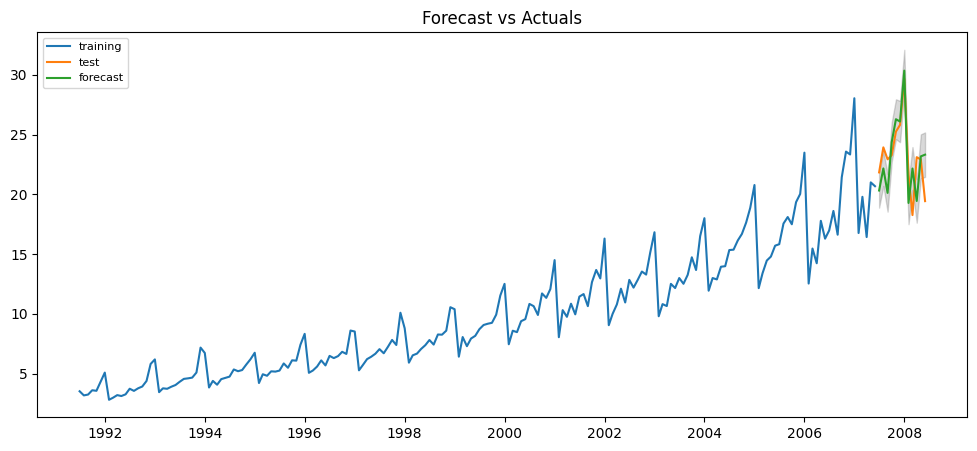

In [53]:
# make series for plotting purpose
fc_series_auto_seasonal = pd.Series(fc_auto_seasonal, index=test_data.index)
lower_series = pd.Series(confint[:, 0], index=test_data.index)
upper_series = pd.Series(confint[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='test')
plt.plot(fc_series_auto_seasonal, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Model Evaluation

In [54]:
#define metrics dataframe which will be used below for
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])


def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    df = pd.DataFrame({'Model': model,
                       'RMSE': rmse,
                       'MAE': mae,
                       'MAPE': mape}, index=[0])
    dataframe = metrics_dataframe.append(df)
    return dataframe

In [55]:
fc_series

date
2007-07-01    20.233472
2007-08-01    20.078415
2007-09-01    19.991156
2007-10-01    19.951690
2007-11-01    19.932134
2007-12-01    19.922819
2008-01-01    19.918307
2008-02-01    19.916137
2008-03-01    19.915090
2008-04-01    19.914586
2008-05-01    19.914343
2008-06-01    19.914226
Name: predicted_mean, dtype: float64

In [56]:
#get all the metrics
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                fc_series.values.flatten(),
                                'Manual ARIMA')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                fc_series_auto_nonseasonal.values.flatten(),
                                'Auto ARIMA Non Seasonal')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                fc_series_auto_seasonal.values.flatten(),
                                'Auto ARIMA Seasonal')



<ipython-input-54-931b17fb3738>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
<ipython-input-54-931b17fb3738>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
<ipython-input-54-931b17fb3738>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)


In [57]:
metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE
0,Auto ARIMA Seasonal,2.336602,1.938992,9.005431
0,Auto ARIMA Non Seasonal,4.261562,3.545344,14.480968
0,Manual ARIMA,4.282390,3.559526,14.470589


In [58]:
# Create a data frame with all the predictions along with the test data
test_pred_df = test_data.copy()

# Add all predictions
test_pred_df = test_pred_df.assign(manual_arima_pred = fc_series.values.flatten(),
                                   auto_nonseasonal_pred = fc_series_auto_nonseasonal.values.flatten(),
                                   auto_seasonal_pred = fc_series_auto_seasonal.values.flatten(),
                                   avg_pred = (fc_series.values.flatten()+
                                               fc_series_auto_nonseasonal.values.flatten()+
                                               fc_series_auto_seasonal.values.flatten())/3)

test_pred_df

,value,manual_arima_pred,auto_nonseasonal_pred,auto_seasonal_pred,avg_pred
date,,,,,
2007-07-01,21.834890,20.233472,21.107307,20.320234,20.553671
2007-08-01,23.930204,20.078415,19.519591,22.168213,20.588740
2007-09-01,22.930357,19.991156,20.670859,20.120788,20.260935
2007-10-01,23.263340,19.951690,19.354526,24.362011,21.222742
2007-11-01,25.250030,19.932134,20.595266,26.282177,22.269859
2007-12-01,25.806090,19.922819,19.320129,26.089970,21.777639
2008-01-01,29.665356,19.918307,20.567025,30.348416,23.611249
2008-02-01,21.654285,19.916137,19.302869,19.278839,19.499282
2008-03-01,18.264945,19.915090,20.545023,22.159167,20.873094


In [59]:
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                test_pred_df['avg_pred'],
                                'Average')


<ipython-input-54-931b17fb3738>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)


In [60]:
metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE
0,Auto ARIMA Seasonal,2.336602,1.938992,9.005431
0,Average,3.093736,2.819033,11.864420
0,Auto ARIMA Non Seasonal,4.261562,3.545344,14.480968
0,Manual ARIMA,4.282390,3.559526,14.470589


## Time Series Cross Validation - see slides

Sources:

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

https://towardsdatascience.com/dont-use-k-fold-validation-for-time-series-forecasting-30b724aaea64